# Sanity Check Training

In [1]:
0

0

In [2]:
import copy
import gc
import logging
import os
import sys
import warnings

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import tqdm
import torch

sc.settings.verbosity = 3

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [4]:
adata_file_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_sample_status_1.h5ad"
)
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
metadata_of_interest = "integration_sample_status"

In [5]:
torch.cuda.is_available()

True

## Vizualization Without Training

In [6]:
adata = ad.read_h5ad(adata_file_path)
display(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

AnnData object with n_obs × n_vars = 11279 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


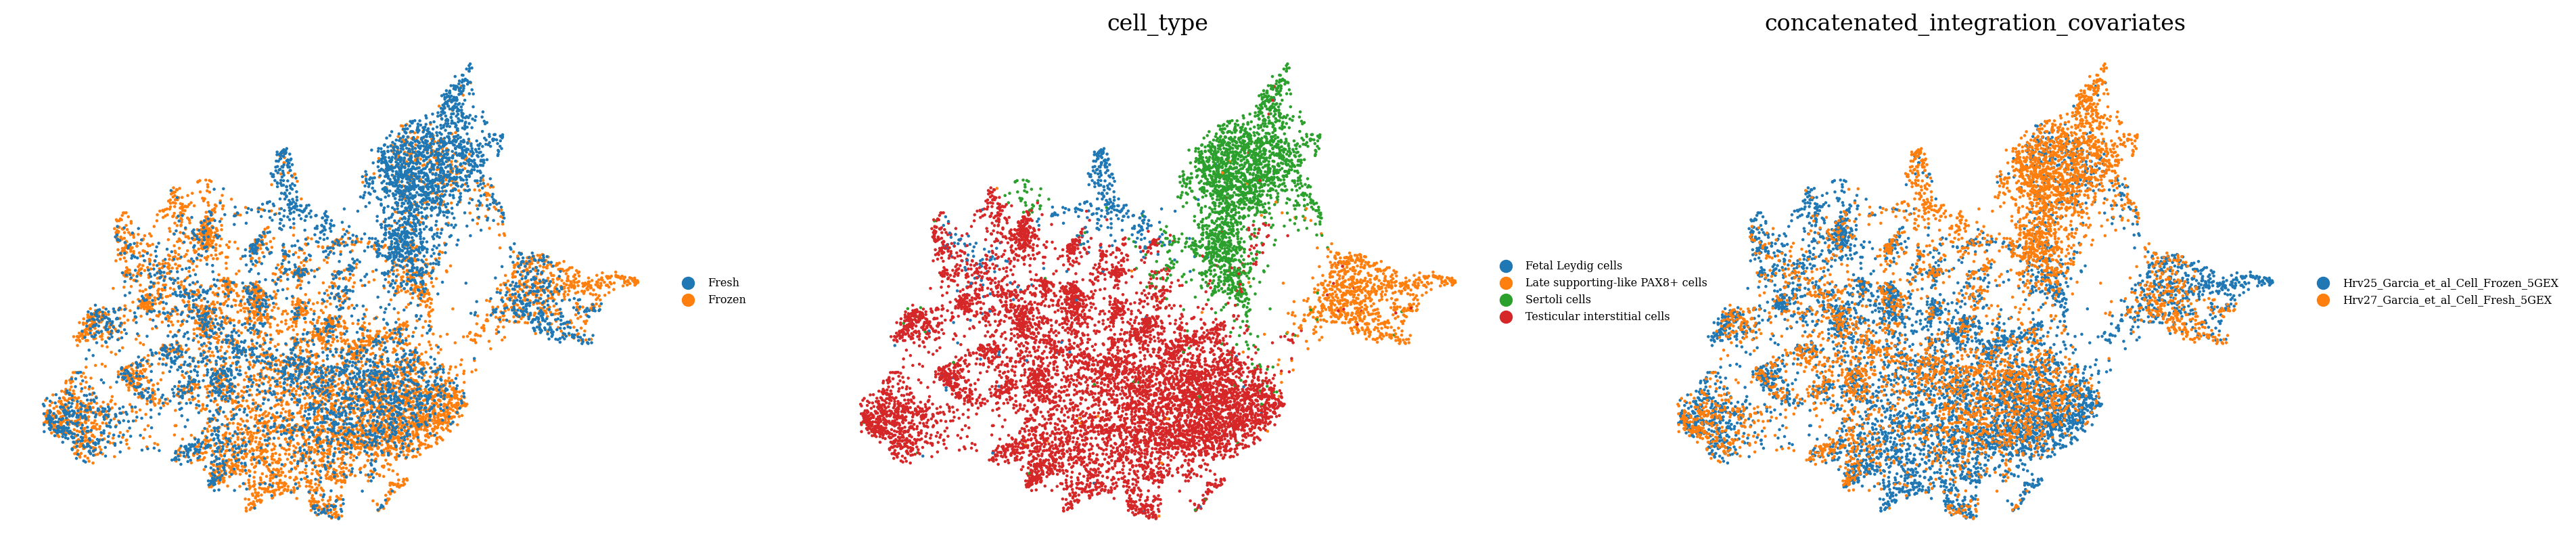

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        adata, 
        color=[metadata_of_interest, "cell_type", "concatenated_integration_covariates"], 
        ncols=3,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )
del adata
gc.collect();

## Training

In [8]:
adata = ad.read_h5ad(adata_file_path)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scvi.model.SCVI.setup_anndata(adata, layer=None, batch_key="concatenated_integration_covariates")
    vae = scvi.model.SCVI(
        adata, 
        n_hidden = 512,
        n_layers=3, 
        n_latent=20, 
        gene_likelihood="nb",
        dropout_rate = 0.1
    )
    vae.train(max_epochs=200)

CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8800, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-8262faab-d72a-5452-87ab-805cd955cc62,MIG-df8da9f3-c925-5d23-b3fa-2dacb31570f1]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 200/200: 100%|████████████████████████████████████████████████████████████████████| 200/200 [03:54<00:00,  1.19it/s, v_num=1, train_loss_step=117, train_loss_epoch=99.3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████████████████████████████████████████████████████████████████████| 200/200 [03:54<00:00,  1.17s/it, v_num=1, train_loss_step=117, train_loss_epoch=99.3]


In [9]:
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, n_neighbors = 30, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


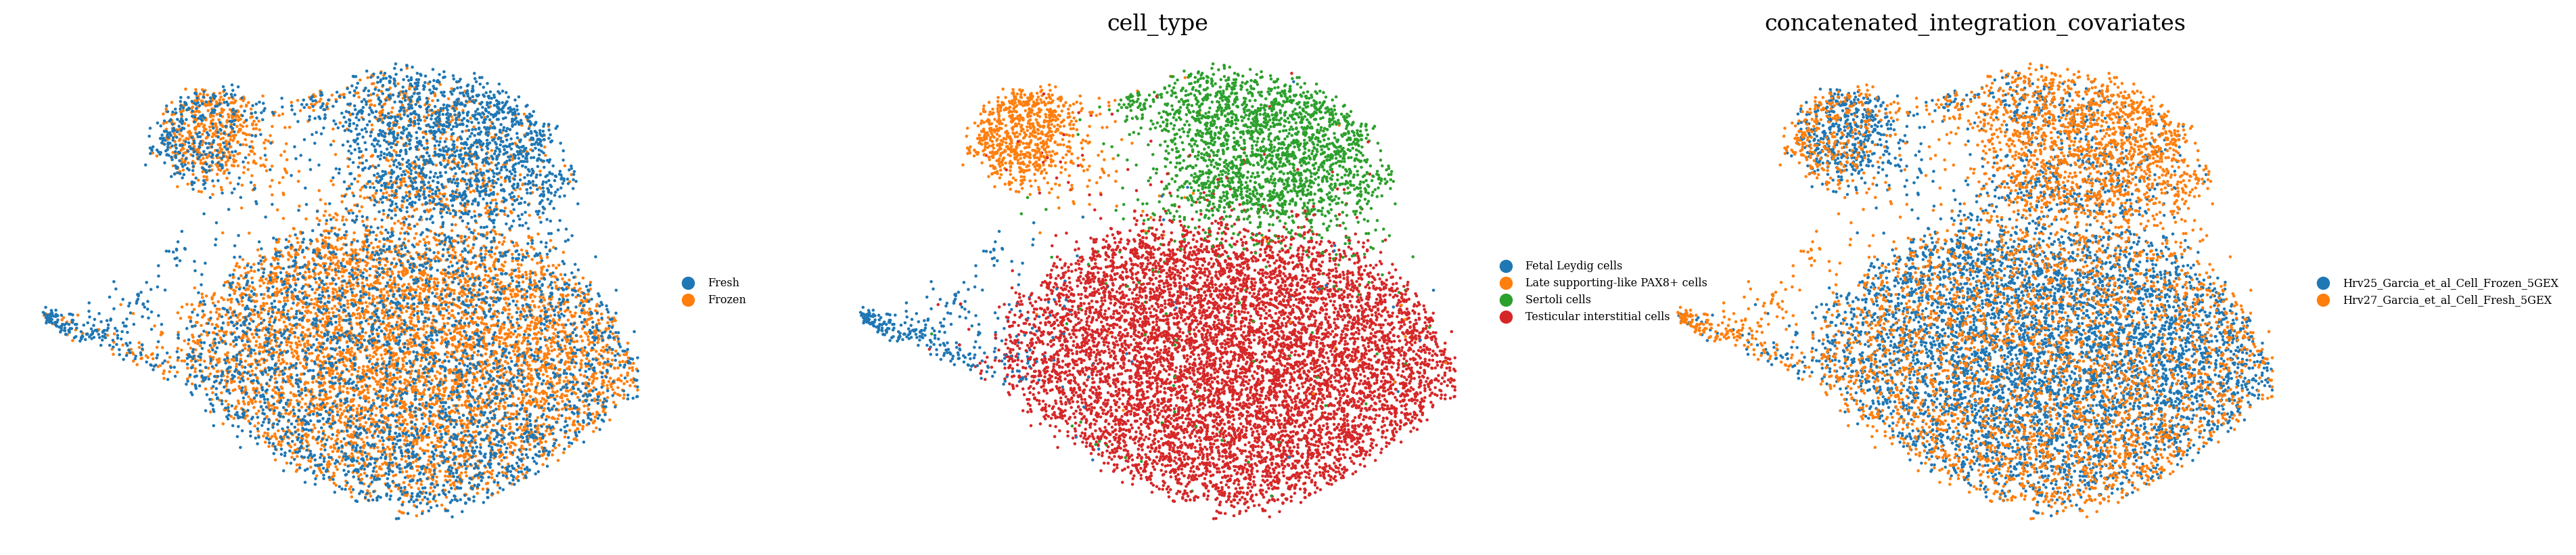

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        adata, 
        color=[metadata_of_interest, "cell_type", "concatenated_integration_covariates"], 
        ncols=3,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )